In [ ]:
#installing fastdtw library to compute dtw distance
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542086 sha256=6f959729595455b32dce03e99ff691145fad98d9f0a337c4cea347a39306c851
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


# **Task 1: Preprocessing the Time-Series Data**

1. Load the HAR dataset and segment the data

In [ ]:
#import all needed libraries
import zipfile
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix

# Extract the ZIP file
def extract_zip(zip_path, extract_path="./dataset"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    return extract_path

# Load the UCI HAR Dataset from given folder
def load_data(data_path):
    # Load raw sensor data
    X_train_acc = np.loadtxt(f"{data_path}/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt")
    X_train_gyro = np.loadtxt(f"{data_path}/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt")
    y_train = np.loadtxt(f"{data_path}/UCI HAR Dataset/train/y_train.txt")

    return X_train_acc, X_train_gyro, y_train

#Segment real Time-Series Data
def segment_data(data_acc, data_gyro, labels, window_size=80, step=20): #set apropriate
    segmented_data, segmented_labels = [], []
    for i in range(0, len(data_acc) - window_size, step):
        segment_acc = data_acc[i:i + window_size]
        segment_gyro = data_gyro[i:i + window_size]

        # Stack accelerometer & gyroscope features
        segment = np.hstack((segment_acc, segment_gyro))

        segmented_data.append(segment)
        segmented_labels.append(labels[i + window_size // 2])  # Assign label of center point

    return np.array(segmented_data), np.array(segmented_labels)


zip_path = "/content/UCI HAR Dataset 3.zip" #path for the zip file
extracted_path = extract_zip(zip_path) #extract the zip file and save it to given path

#Load raw sensor data using the user defined function
X_train_acc, X_train_gyro, y_train = load_har_data(extracted_path)

#load Segment raw time-series data using user defined function
segmented_data, segmented_labels = segment_data(X_train_acc, X_train_gyro, y_train)

2.Compute pairwise distances between time-series segments using:

a) Euclidean distance

b) DTW distance

Pairwise distance using Euclidean distance

In [ ]:
#function to Compute Euclidean distance matrix
def euclidean_mat(data):
    return euclidean_distances(data.reshape(len(data), -1))

euclidean_matrix = euclidean_mat(segmented_data)

print("Euclidean matrix: ", euclidean_matrix)
print("Euclidean matrix shape : ", euclidean_matrix.shape)

Euclidean matrix:  [[  0.          75.39500521  89.35876379 ...  94.96009052 102.67768826
   94.42038792]
 [ 75.39500521   0.          85.21588265 ...  86.45697538 102.78923137
   99.18785108]
 [ 89.35876379  85.21588265   0.         ...  68.45695992  96.74780724
  101.87553786]
 ...
 [ 94.96009052  86.45697538  68.45695992 ...   0.          99.72755304
  107.30141859]
 [102.67768826 102.78923137  96.74780724 ...  99.72755304   0.
  109.79130938]
 [ 94.42038792  99.18785108 101.87553786 ... 107.30141859 109.79130938
    0.        ]]
Euclidean matrix shape :  (364, 364)


pairwise distance using DTW distance

In [ ]:
# function to Compute DTW distance matrix
def compute_dtw_mat(data):
    n = len(data)
    dtw_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):  # Compute only upper triangle (symmetric)
            distance, k = fastdtw(data[i], data[j], dist=euclidean)
            dtw_matrix[i, j] = distance
            dtw_matrix[j, i] = distance  # Symmetric matrix
    return dtw_matrix

# Compute distance matrices
dtw_matrix = compute_dtw_mat(segmented_data)

print("dtw matrix: ", dtw_matrix)
print("dtw matrix shape : ", dtw_matrix.shape)

dtw matrix:  [[  0.         187.57492448 410.90198915 ... 551.57490498 878.8243474
  810.32962903]
 [187.57492448   0.         195.73299031 ... 449.108732   920.46684821
  842.10844245]
 [410.90198915 195.73299031   0.         ... 493.21622295 746.14405541
  878.54818617]
 ...
 [551.57490498 449.108732   493.21622295 ...   0.         356.42632057
  560.05035392]
 [878.8243474  920.46684821 746.14405541 ... 356.42632057   0.
  254.88622   ]
 [810.32962903 842.10844245 878.54818617 ... 560.05035392 254.88622
    0.        ]]
dtw matrix shape :  (364, 364)


3. Construct a similarity matrix W, where Wij measures similarity between time-series xi and xj .

In [ ]:
#function to Construct Similarity Matrix
def construct_similarity_matrix(distance_matrix, sigma=1.0):
    W = np.exp(-distance_matrix ** 2 / (2 * sigma ** 2))
    np.fill_diagonal(W, 0)  # No self-similarity
    return csr_matrix(W)  # Return sparse matrix

# Compute similarity matrices from the user defined function
similar_dtw = construct_similarity_matrix(dtw_matrix)
similar_euclidean = construct_similarity_matrix(euclidean_matrix)

print("DTW Similarity Matrix Shape:", similar_dtw.shape)
print("Euclidean Similarity Matrix Shape:", similar_euclidean.shape)


DTW Similarity Matrix Shape: (364, 364)
Euclidean Similarity Matrix Shape: (364, 364)


# **Task 2: Apply Diffusion Maps for Dimensionality Reduction**

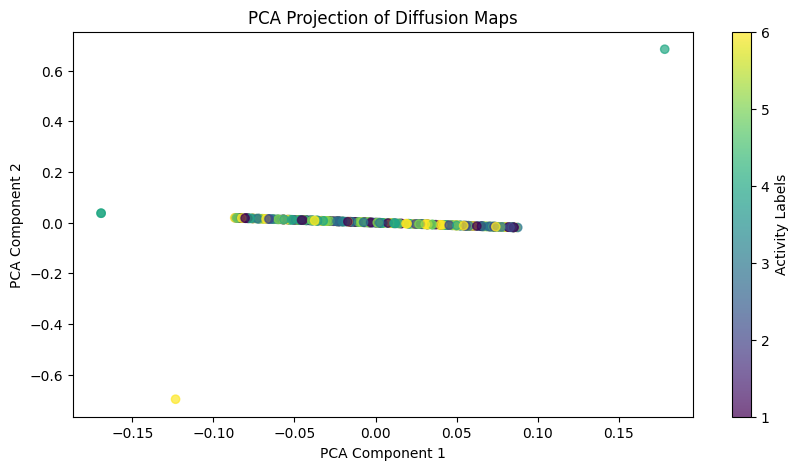

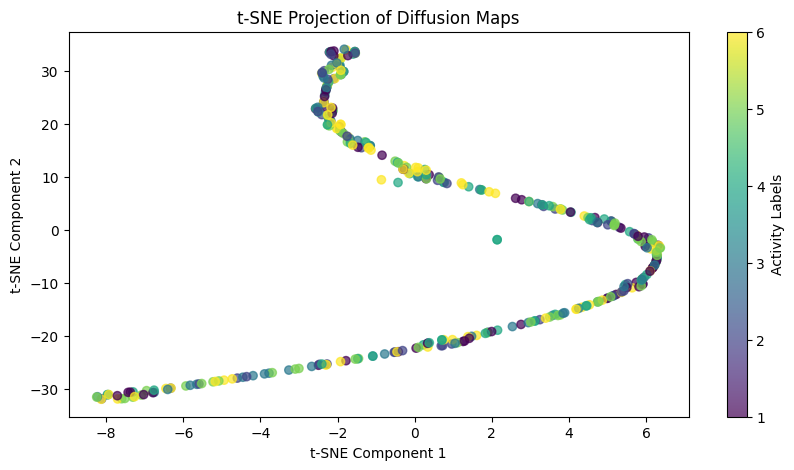

In [ ]:
#importing all the needed libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# function to Construct Diffusion Kernel
def compute_diffusion_kernel(distance_matrix, epsilon=1.0):
    K = np.exp(-distance_matrix ** 2 / epsilon)
    np.fill_diagonal(K, 0)
    return K

# Compute Normalized Graph Laplacian
def compute_graph_laplacian(K, epsilon=1e-5):
    D = np.diag(K.sum(axis=1))  # Degree matrix
    D += np.eye(D.shape[0]) * epsilon  # Regularization to avoid singular matrix
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))  # Compute root of D
    L = np.dot(D_inv_sqrt, np.dot(K, D_inv_sqrt))  # Normalized Laplacian
    return L

# Diffusion Coordinates (which will be the leading Eigenvectors)
def diffusion_maps(L, num_eigenvectors=3):
    eigenvalues, eigenvectors = eigsh(L, k=num_eigenvectors+1, which='LM')  # Find top eigenvectors
    diffusion_coords = eigenvectors[:, 1:num_eigenvectors+1]  # Ignore first eigenvector
    return diffusion_coords

# Apply PCA for Visualization
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

# Apply t-SNE for Visualization
def apply_tsne(data, n_components=2):
    tsne = TSNE(n_components=n_components, perplexity=30, random_state=42)
    return tsne.fit_transform(data)

# Compute Diffusion Kernel from DTW distance matrix
Kernel_dtw = compute_diffusion_kernel(dtw_matrix)

# Compute Graph Laplacian
Laplacian_dtw = compute_graph_laplacian(Kernel_dtw)

# Get Diffusion Coordinates (Top 3 eigenvectors)
diffusion_coords = diffusion_maps(Laplacian_dtw, num_eigenvectors=3)

# PCA Transformation
pca_result = apply_pca(diffusion_coords, n_components=2)

# t-SNE Transformation
tsne_result = apply_tsne(diffusion_coords, n_components=2)

# Scatter Plot for PCA
plt.figure(figsize=(10, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=segmented_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Activity Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Diffusion Maps")
plt.show()

# Scatter Plot for t-SNE
plt.figure(figsize=(10, 5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=segmented_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Activity Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection of Diffusion Maps")
plt.show()


# **Task 3: Clustering in the Diffusion Space**

1. Apply K-Means or DBSCAN to the diffusion map embeddings.
2. Evaluate clustering performance
using:
• Adjusted Rand Index (ARI)
• Silhouette Score

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

def clustering_evaluation(diffusion_embeddings, true_labels, n_clusters):

    #  Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(diffusion_embeddings)

    #  Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(diffusion_embeddings)

    #  Evaluate clustering using ARI & Silhouette Score
    ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)
    sil_kmeans = silhouette_score(diffusion_embeddings, kmeans_labels)

    ari_dbscan = adjusted_rand_score(true_labels, dbscan_labels)
    sil_dbscan = silhouette_score(diffusion_embeddings, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

    #  Print the evaluation metrics
    print(" Clustering Evaluation ")
    print(f"K-Means -> ARI: {ari_kmeans:.4f}, Silhouette Score: {sil_kmeans:.4f}")
    print(f"DBSCAN  -> ARI: {ari_dbscan:.4f}, Silhouette Score: {sil_dbscan:.4f}")

    return kmeans_labels, dbscan_labels

# Ensure used labels are unique
n_clusters = len(np.unique(segmented_labels))

# Check if label size matches diffusion coordinates
print(f"Diffusion Embeddings Shape: {diffusion_coords.shape}")
print(f"Segmented Labels Shape: {segmented_labels.shape}")

# Call clustering with correct labels
kmeans_labels, dbscan_labels = clustering_evaluation(diffusion_coords, segmented_labels, n_clusters)


Diffusion Embeddings Shape: (364, 3)
Segmented Labels Shape: (364,)
 Clustering Evaluation 
K-Means -> ARI: -0.0018, Silhouette Score: 0.5863
DBSCAN  -> ARI: -0.0001, Silhouette Score: 0.9024


# **Task 4: Visualization and Interpretation**

# 1. Scatter Plot the diffusion embeddings, color-coded by activity labels.

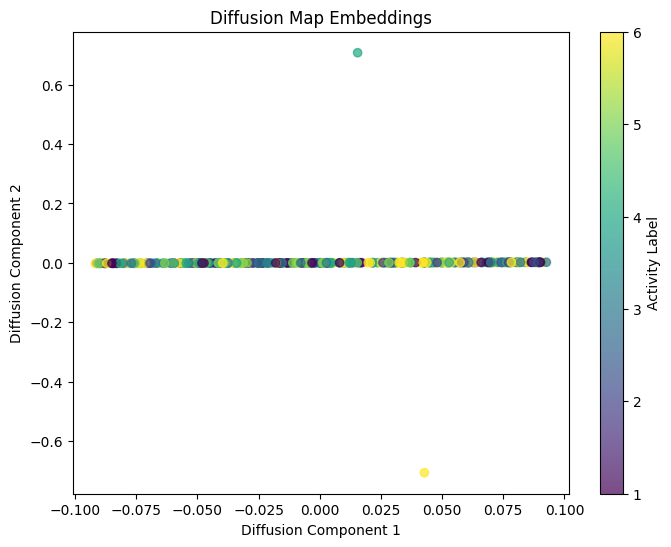

In [ ]:
import matplotlib.pyplot as plt

# Plot diffusion embeddings
plt.figure(figsize=(8, 6))
scatter = plt.scatter(diffusion_coords[:, 0], diffusion_coords[:, 1], c=segmented_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Activity Label")
plt.xlabel("Diffusion Component 1")
plt.ylabel("Diffusion Component 2")
plt.title="Diffusion Map Embeddings"
plt.show()

# 2. Compare clustering quality
using:

• PCA

• t-SNE

• Raw feature space

• Diffusion Maps

 PCA Visualization

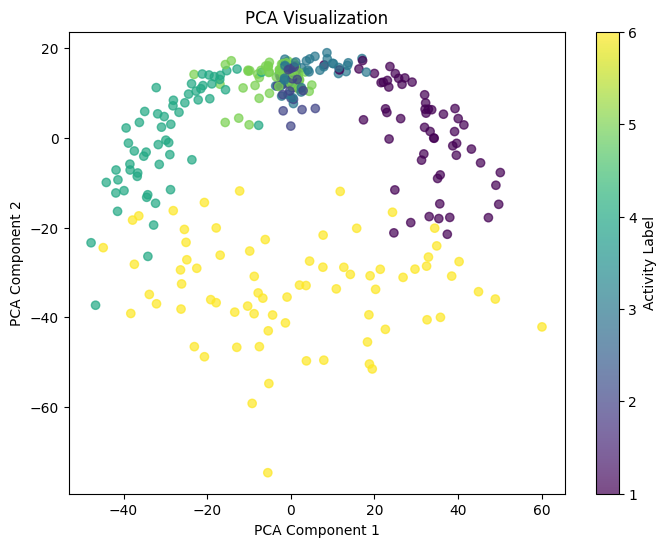

In [ ]:
from sklearn.decomposition import PCA

# PCA on segmented data
pca = PCA(n_components=2)
X=segmented_data.reshape(segmented_data.shape[0], -1)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=segmented_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Activity Label")
plt.title="PCA Visualization"
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(title)
plt.show()


 t-SNE Visualization

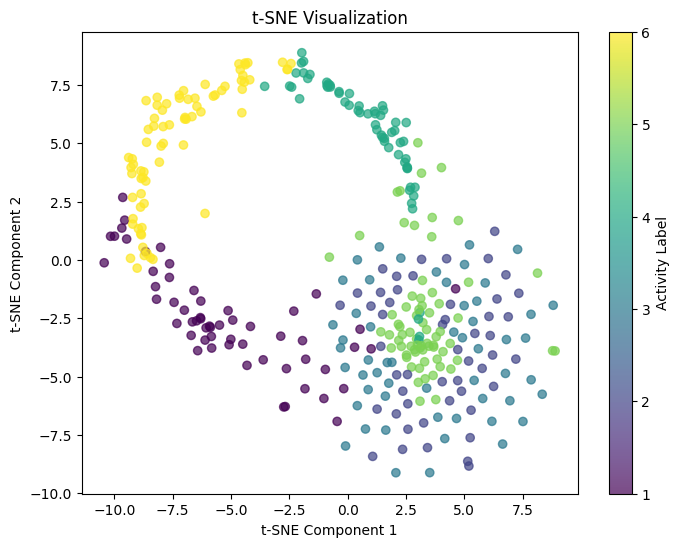

In [ ]:
from sklearn.manifold import TSNE

# t-SNE on segmented data
X=segmented_data.reshape(segmented_data.shape[0], -1)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=segmented_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Activity Label")
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title(title)
plt.show()

raw feature space

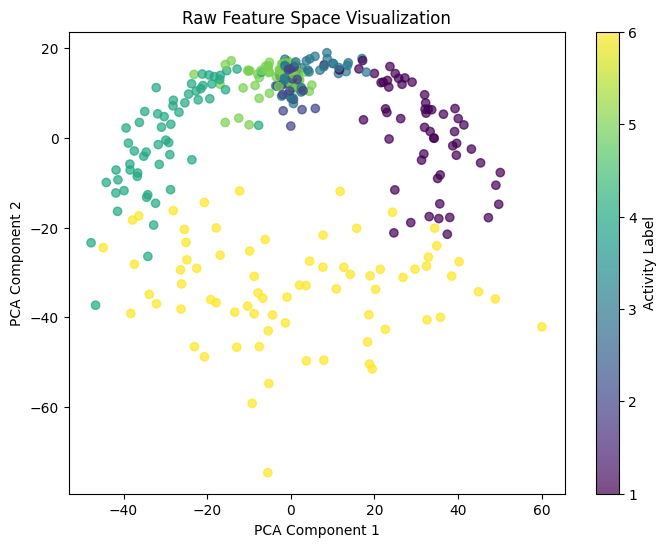

In [ ]:
# Visualize Raw Feature Space on segmented data

# Reshape the data (flattening for PCA)
reshape_seg_data = segmented_data.reshape(segmented_data.shape[0], -1)

pca = PCA(n_components=2)
seg_data_pca = pca.fit_transform(reshape_seg_data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=segmented_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Activity Label")
plt.title("Raw Feature Space Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(title)
plt.show()